In [1]:
# =============================================================================
# 1. IMPORT LIBRARIES & SETUP
# =============================================================================
import pandas as pd
import datetime as dt
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
import joblib
import shap


print("All libraries imported successfully.")
# Create a directory to save models if it doesn't exist
os.makedirs('../models', exist_ok=True)


# =============================================================================
# 2. DATA PREPARATION
# =============================================================================
data_path = r'C:\Users\mridul\Bennett_clg\DA_Project\raw\archive'
print(f"\nLoading datasets from: {data_path}")

customers = pd.read_csv(os.path.join(data_path, 'olist_customers_dataset.csv'))
orders = pd.read_csv(os.path.join(data_path, 'olist_orders_dataset.csv'))
order_items = pd.read_csv(os.path.join(data_path, 'olist_order_items_dataset.csv'))
payments = pd.read_csv(os.path.join(data_path, 'olist_order_payments_dataset.csv'))

print("Merging and cleaning data...")
df = orders.merge(customers, on='customer_id')
df = df.merge(order_items, on='order_id')
df = df.merge(payments, on='order_id')
df_cleaned = df[df['order_status'] == 'delivered'].copy()

transactions = df_cleaned[[
    'order_id', 'customer_unique_id', 'order_purchase_timestamp', 'payment_value',
]].rename(columns={
    'order_id': 'transaction_id', 'customer_unique_id': 'customer_id',
    'order_purchase_timestamp': 'txn_date', 'payment_value': 'amount',
}).drop_duplicates()

transactions['txn_date'] = pd.to_datetime(transactions['txn_date'])
print("Data preparation complete.")



c:\Users\mridul\Bennett_clg\DA_Project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully.

Loading datasets from: C:\Users\mridul\Bennett_clg\DA_Project\raw\archive
Merging and cleaning data...
Data preparation complete.


In [2]:

# =============================================================================
# 3. RFM CALCULATION
# =============================================================================
print("\nCalculating RFM scores...")
analysis_date = transactions['txn_date'].max() + dt.timedelta(days=1)
rfm = transactions.groupby('customer_id').agg({
    'txn_date': lambda date: (analysis_date - date.max()).days,
    'transaction_id': 'nunique',
    'amount': 'sum'
}).rename(columns={
    'txn_date': 'recency', 'transaction_id': 'frequency', 'amount': 'monetary'
})
print("RFM calculation complete.")





Calculating RFM scores...
RFM calculation complete.


In [ ]:
# =============================================================================
# 4. RFM SEGMENTATION (K-MEANS CLUSTERING)
# =============================================================================
print("\nPerforming customer segmentation...")
rfm_log = np.log1p(rfm)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

# --- Model Evaluation: Finding the Optimal Number of Clusters ---
print("Evaluating optimal number of clusters (k)...")
sse = {}
silhouette_scores = {}
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_
    silhouette_scores[k] = silhouette_score(rfm_scaled, kmeans.labels_)

# Plotting the Elbow Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(list(sse.keys()), list(sse.values()), 'o-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal k")

# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'o-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Optimal k")
plt.show()
print("Based on the charts, k=4 appears to be a good choice, offering a reasonable balance of inertia and a peak in silhouette score.")




Performing customer segmentation...
Evaluating optimal number of clusters (k)...


KeyboardInterrupt: 

Showing the original RFM distributions (they are skewed):


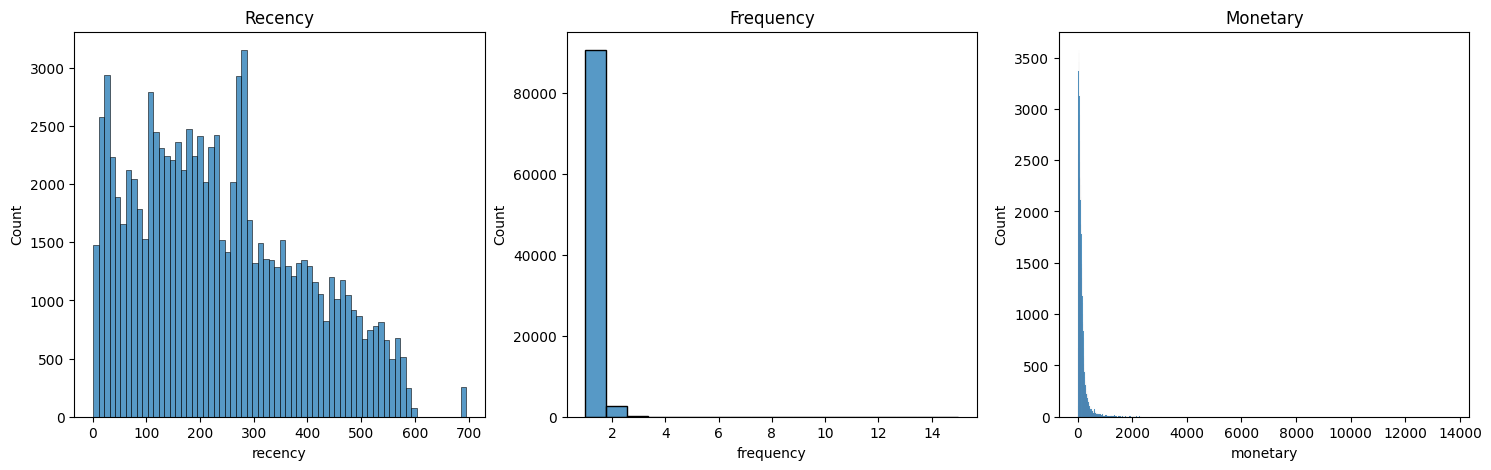


Data has been scaled successfully. Here's a sample:


,recency,frequency,monetary
customer_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.470385,-0.170191,0.289986
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.442302,-0.170191,-1.715608
0000f46a3911fa3c0805444483337064,1.202051,-0.170191,-0.320042
0000f6ccb0745a6a4b88665a16c9f078,0.651914,-0.170191,-1.148203
0004aac84e0df4da2b147fca70cf8255,0.536031,-0.170191,0.692255


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Part 1: Visualize the Skew ---
print("Showing the original RFM distributions (they are skewed):")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['recency'], ax=axes[0]).set_title('Recency')
sns.histplot(rfm['frequency'], ax=axes[1]).set_title('Frequency')
sns.histplot(rfm['monetary'], ax=axes[2]).set_title('Monetary')
plt.show()


# --- Part 2: Fix Skew and Scale the Data ---

# Apply a log transformation to reduce the skewness of the data
# We use np.log1p which is safe for values of 0
rfm_log = np.log1p(rfm)

# Scale the data so each feature has an equal influence
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Convert the scaled data back into a DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print("\nData has been scaled successfully. Here's a sample:")
display(rfm_scaled.head())

In [4]:

# --- Final Model Training and Segmentation ---
k = 4
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled)
rfm['cluster'] = kmeans_final.labels_

# --- Analyze and Name Segments ---
cluster_analysis = rfm.groupby('cluster')[['recency', 'frequency', 'monetary']].mean()
segment_map = {
    cluster_analysis.sort_values('monetary', ascending=False).index[0]: 'Champions',
    cluster_analysis.sort_values('recency', ascending=True).index[0]: 'New Customers',
    cluster_analysis.sort_values('recency', ascending=False).index[0]: 'At-Risk',
    cluster_analysis.sort_values('frequency', ascending=False).index[1]: 'Potential Loyalists'
}
rfm['segment'] = rfm['cluster'].map(segment_map)
print("Customer segmentation complete.")


# =============================================================================
# 5. LTV PREDICTION
# =============================================================================
print("\nPredicting Customer Lifetime Value (LTV)...")
lifetimes_summary = summary_data_from_transaction_data(
    transactions, customer_id_col='customer_id',
    datetime_col='txn_date', monetary_value_col='amount'
)
repeat_customers = lifetimes_summary[lifetimes_summary['frequency'] > 0]

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(repeat_customers['frequency'], repeat_customers['recency'], repeat_customers['T'])
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(repeat_customers['frequency'], repeat_customers['monetary_value'])

predicted_ltv = ggf.customer_lifetime_value(
    bgf, lifetimes_summary['frequency'], lifetimes_summary['recency'],
    lifetimes_summary['T'], lifetimes_summary['monetary_value'],
    time=12, freq='M'
)
rfm = rfm.merge(predicted_ltv.rename('predicted_ltv'), left_index=True, right_index=True, how='left')
rfm['predicted_ltv'].fillna(0, inplace=True)
print("LTV prediction complete.")



Customer segmentation complete.

Predicting Customer Lifetime Value (LTV)...
LTV prediction complete.


In [6]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter

# --- 1. Prepare data for the lifetimes library ---
# This creates a summary table with frequency, recency, and T (age of customer).
lifetimes_summary = summary_data_from_transaction_data(
    transactions,
    customer_id_col='customer_id',
    datetime_col='txn_date',
    monetary_value_col='amount'
)

# --- 2. Fit the models ONLY on customers who have made more than one purchase ---
# The models work best on repeat customers.
repeat_customers = lifetimes_summary[lifetimes_summary['frequency'] > 0]

# Fit the BG/NBD model to predict purchase frequency
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(repeat_customers['frequency'], repeat_customers['recency'], repeat_customers['T'])

# Fit the Gamma-Gamma model to predict purchase value
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(repeat_customers['frequency'], repeat_customers['monetary_value'])

# --- 3. Calculate the 12-month LTV for all customers ---
# This will generate predictions for repeat customers and NaNs for the rest.
predicted_ltv = ggf.customer_lifetime_value(
    bgf,
    lifetimes_summary['frequency'],
    lifetimes_summary['recency'],
    lifetimes_summary['T'],
    lifetimes_summary['monetary_value'],
    time=12,  # time in months
    freq='M'  # 'M' for months
)

# --- 4. Add LTV back to the main RFM table ---
# Merge the predicted LTV. This will create the 'predicted_ltv' column.
rfm = rfm.merge(predicted_ltv.rename('predicted_ltv'), left_index=True, right_index=True, how='left')

# Now that the column exists, fill in 0 for customers who had no prediction.
rfm['predicted_ltv'].fillna(0, inplace=True)

print("\nFinal RFM table with corrected LTV:")
display(rfm.sort_values(by='predicted_ltv', ascending=False).head(10))

# --- 5. Re-save the data for your dashboard ---
rfm.to_csv('final_customer_data.csv')
print("\nCorrected data saved to final_customer_data.csv")


Final RFM table with corrected LTV:


,recency,frequency,monetary,cluster,segment,predicted_ltv_x,predicted_ltv_y,predicted_ltv
customer_id,,,,,,,,
4facc2e6fbc2bffab2fea92d2b4aa7e4,16,4,1760.75,2,Champions,22.862853,22.862853,22.862853
c8460e4251689ba205045f3ea17884a1,22,4,4655.91,2,Champions,16.956121,16.956121,16.956121
fe81bb32c243a86b2f86fbf053fe6140,70,5,1590.76,2,Champions,16.790038,16.790038,16.790038
397b44d5bb99eabf54ea9c2b41ebb905,73,4,1756.53,2,Champions,16.309499,16.309499,16.309499
7febafa06d9d8f232a900a2937f04338,1,1,61.29,3,New Customers,14.821960,14.821960,14.821960
f80013faf776e37bcea7634d59c2181e,1,1,74.21,3,New Customers,14.821960,14.821960,14.821960
21dbe8eabd00b34492a939c540e2b1a7,1,1,14.29,3,New Customers,14.821960,14.821960,14.821960
afbcfd0b9c5233e7ccc73428526fbb52,1,1,497.25,3,New Customers,14.821960,14.821960,14.821960
0421e7a23f21e5d54efed456aedbc513,1,1,119.42,3,New Customers,14.821960,14.821960,14.821960



Corrected data saved to final_customer_data.csv


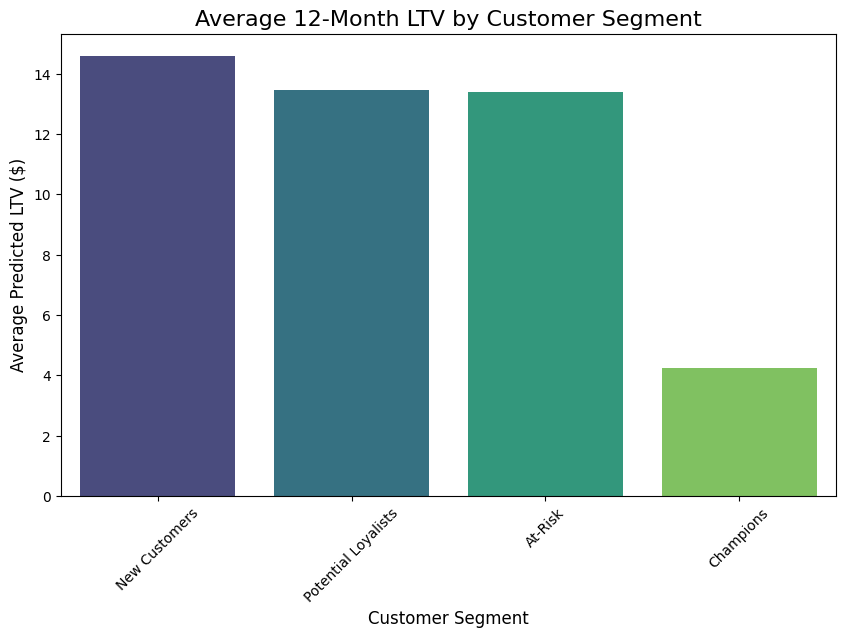

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average predicted LTV for each segment
ltv_by_segment = rfm.groupby('segment')['predicted_ltv'].mean().sort_values(ascending=False)

# Create a bar plot to visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x=ltv_by_segment.index, y=ltv_by_segment.values, palette='viridis')

plt.title('Average 12-Month LTV by Customer Segment', fontsize=16)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Average Predicted LTV ($)', fontsize=12)
plt.xticks(rotation=45)
plt.show()